# Quantization in TFLite
In this assignment you will get to explore quantizing a model in TFLite again. This time some of the code will be missing and you'll need to fill it in. The model we are exploring today is a computer vision model that recognizes hand gestures for the rock, paper, scissors game!

## Set up the problem

### Import packages

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

# Desired versions
tf_version = "2.10.0"
hub_version = "0.12.0"
datasets_version = "4.6.0"

# Check if any of the packages is not the correct version
if (tf.__version__ != tf_version or
    hub.__version__ != hub_version or
    tfds.__version__ != datasets_version):

    print(f"Current TensorFlow version: {tf.__version__}, switching to {tf_version}")
    print(f"Current TensorFlow Hub version: {hub.__version__}, switching to {hub_version}")
    print(f"Current TensorFlow Datasets version: {tfds.__version__}, switching to {datasets_version}")

    # Uninstall current TensorFlow version
    !pip uninstall -y tensorflow tensorflow_hub tensorflow_datasets

    # Install the specified versions of TensorFlow, TensorFlow Hub, and TensorFlow Datasets
    !pip install tensorflow==2.10 tensorflow_hub==0.12.0 tensorflow_datasets==4.6.0

    # After installation, prompt the user to restart the runtime
    print("Specified versions of TensorFlow, TensorFlow Hub, and TensorFlow Datasets installed.")
    print("Please click on the Runtime > Restart session and run all.")
else:
    print("All packages are already at the specified versions.")

All packages are already at the specified versions.


In [2]:
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tqdm import tqdm
import pathlib

### Download the dataset

In [3]:
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label


(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'rock_paper_scissors', split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True, as_supervised=True)
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteVS2RCE/rock_paper_scissors-train.tfrecord*…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteVS2RCE/rock_paper_scissors-test.tfrecord*.…

Dataset rock_paper_scissors downloaded and prepared to ~/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


### Build and train a baseline model

In [4]:
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
63/63 [==============================] - 58s 839ms/step - loss: 0.4433 - accuracy: 0.8705 - val_loss: 0.1269 - val_accuracy: 0.9861
Epoch 2/5
63/63 [==============================] - 48s 769ms/step - loss: 0.0844 - 

### Save the baseline model

In [6]:
#model save
ROCK_PAPER_SCISSORS_SAVED_MODEL = "exp_saved_model"
tf.saved_model.save(model, ROCK_PAPER_SCISSORS_SAVED_MODEL)


## Now its your turn
### Convert the model to TFLite

Hint: You'll need to use the saved model to generate a converter and then run it. This will only require two lines of code! Isn't TFLite amazing!

In [8]:
"""You can instantiate the converter, leveraging the saved model file as noted in the hint, using the handy saved model function shown below:"""
converter =  tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPER_SCISSORS_SAVED_MODEL)
tflite_model = converter.convert()
"""It’s that simple! TFLite does all of the heavy lifting under the hood for you."""

tflite_models_dir = pathlib.Path("/tmp/")
tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)
# This will report back the file size in bytes
# you will note that this model is too big for our Arduino
# but would work on a mobile phone

8880404

### Test the model

Hint: You'll need to definite an Interpreter that we can use to run the model. Again TFLite being amazing will only require you to write one line of code!

In [9]:
# Load TFLite model and allocate tensors.
TFLITE_MODEL_FILE = '/tmp/model1.tflite'

"""Defining the interpreter (again leveraging a saved model -- this time our TFLite model) is also a simple one line command:"""
interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL_FILE)
interpreter.allocate_tensors()

In [11]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

# This will tell you how many of the predictions were correct
score = 0
for item in range(0,99):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("\nOut of 100 predictions I got " + str(score) + " correct")

100%|██████████| 100/100 [00:02<00:00, 45.96it/s]


Out of 100 predictions I got 87 correct


## Plot the results

To explore the results a little more we've include the plotting code below which will help you visualize which images the model is getting correct and incorrect. **If you'd like to improve the model's performance we suggest modifying the code in "Build and train a baseline model." Some ideas include, training for more epochs, choosing a different model architecture, and changing the optimizer. If you are feeling ambitious we'd suggest trying out quantization aware training!**

In [12]:
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

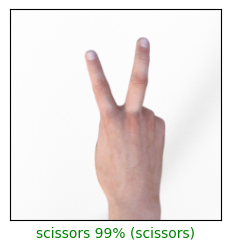

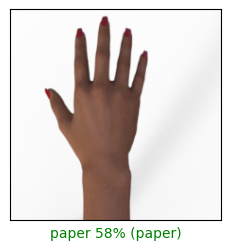

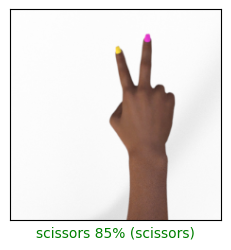

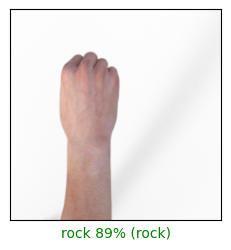

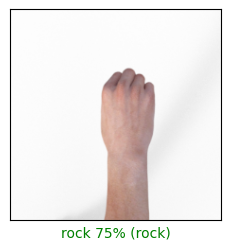

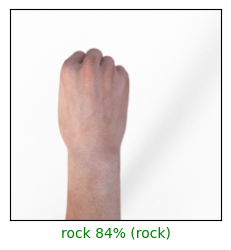

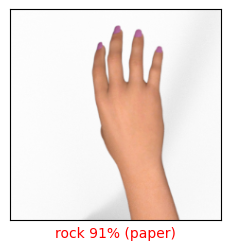

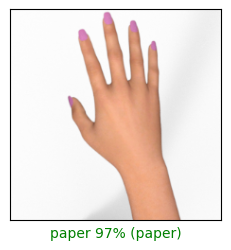

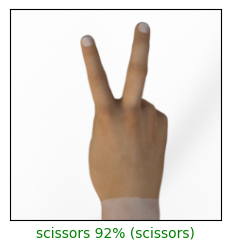

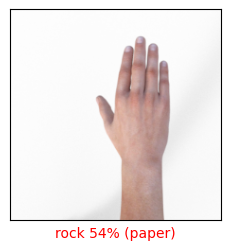

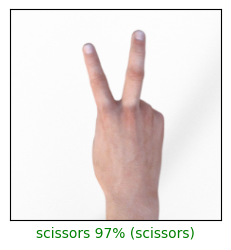

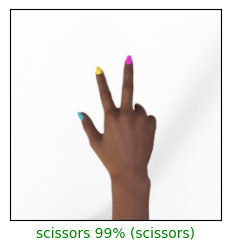

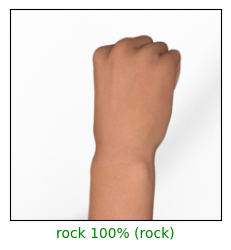

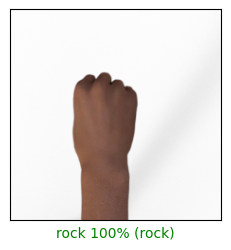

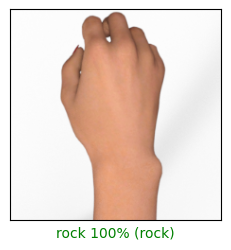

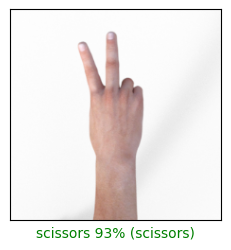

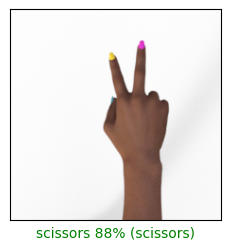

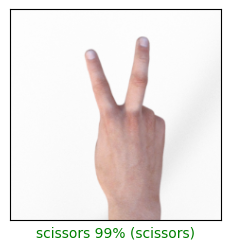

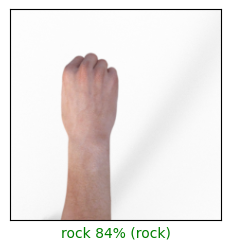

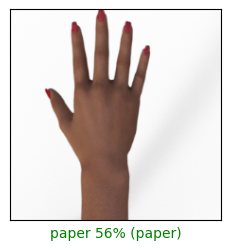

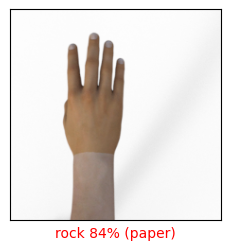

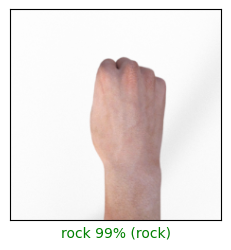

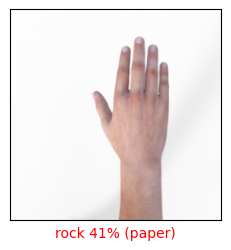

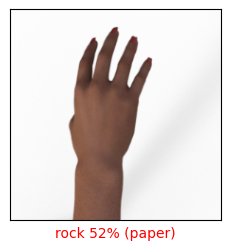

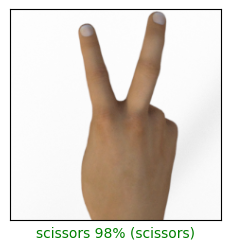

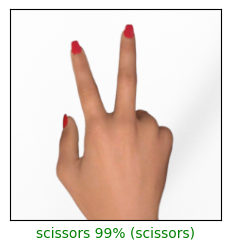

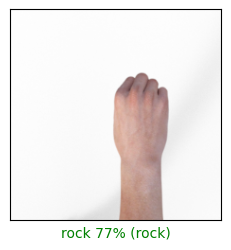

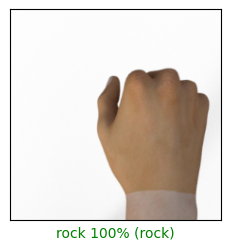

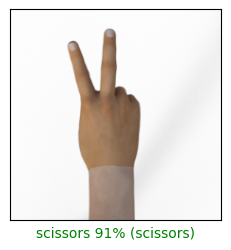

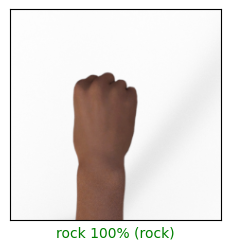

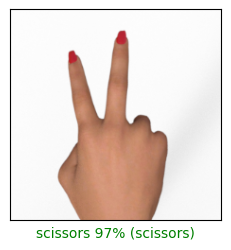

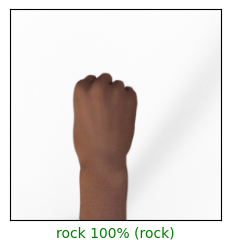

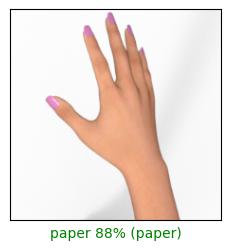

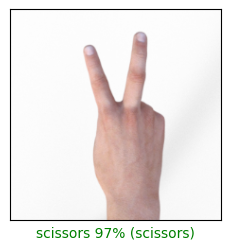

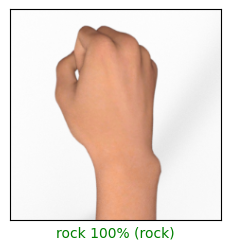

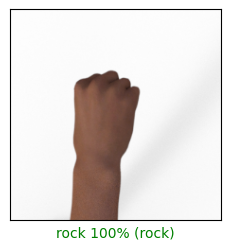

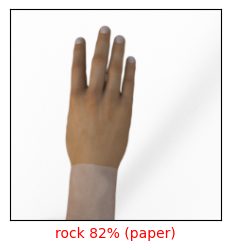

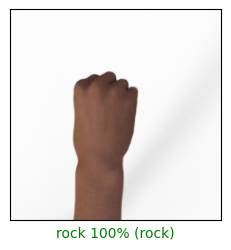

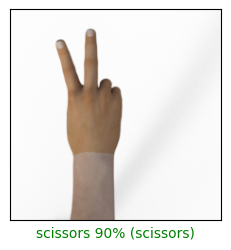

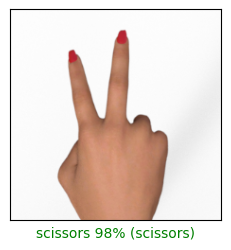

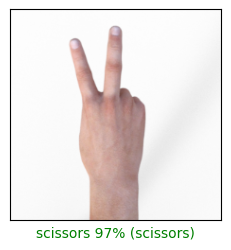

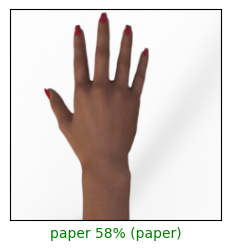

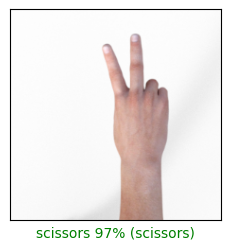

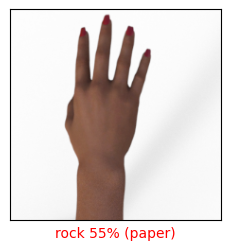

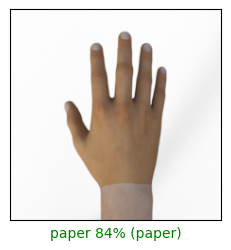

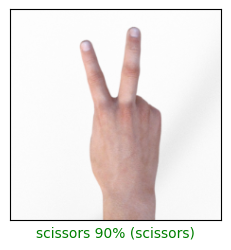

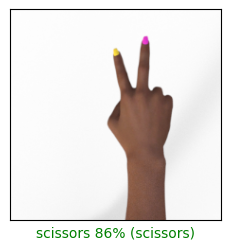

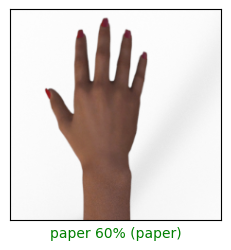

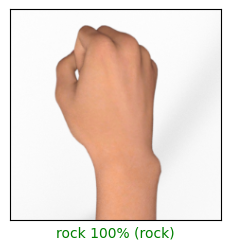

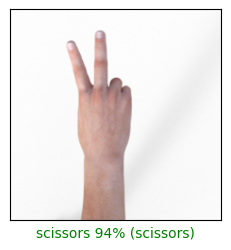

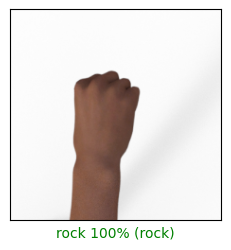

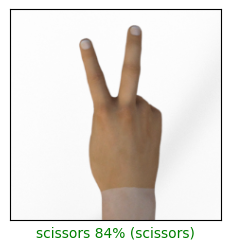

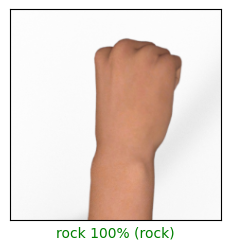

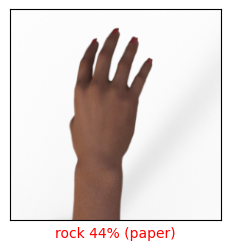

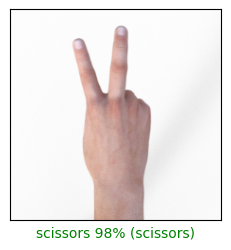

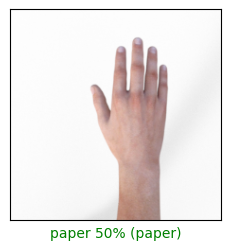

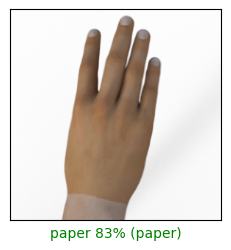

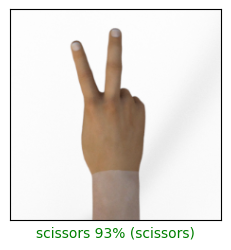

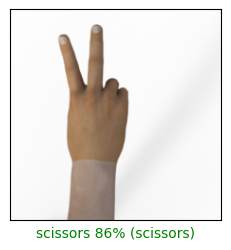

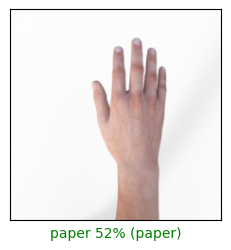

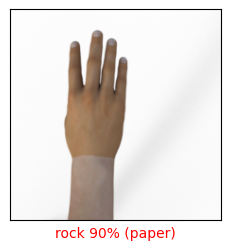

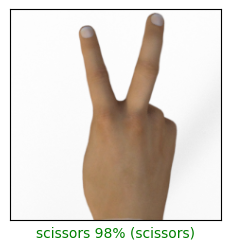

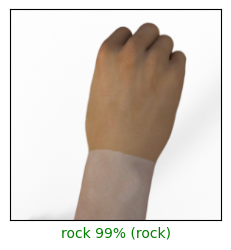

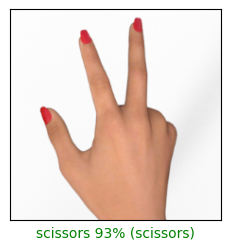

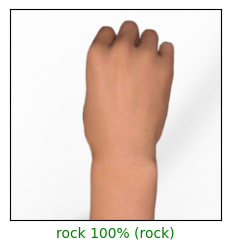

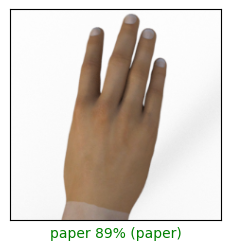

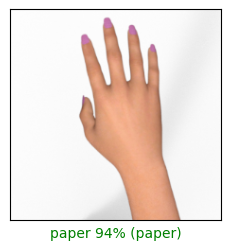

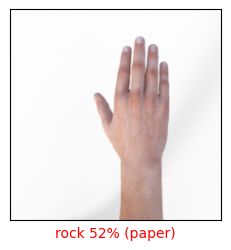

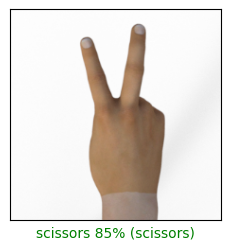

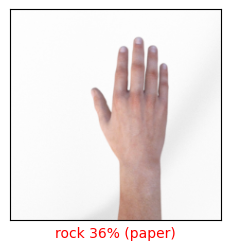

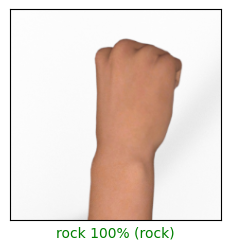

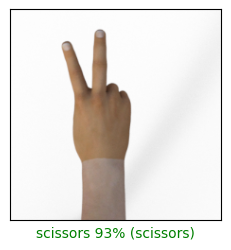

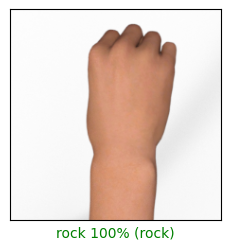

In [13]:
#@title Visualize the outputs { run: "auto" }
max_index = 73 #@param {type:"slider", min:0, max:99, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()

#Further Study

We are going to dive a little deeper into the ideas behind post-training quantization and optimization in the next section. That said, if you'd like to check out how these steps are implemetned in Tensorflow Lite, please check out the user guides at https://www.tensorflow.org/lite/performance/post_training_quantization.